# Loop over MERGEDIR satellite datafiles, making images 



In [1]:
# !pip install xarray matplotlib cartopy xemsf netCDF4 

In [2]:
# !pip install OWSLib  # for Blue Marble access
# !pip install vsrife

In [3]:
# !mkdir /Users/bmapes/Box/Sky_Symphony_Box/IRMA2017/MERGEDIR_BOXES/frames2

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from pathlib import Path
import os
from subprocess import run
from matplotlib.colors import LinearSegmentedColormap, to_rgba
import matplotlib.colors as mcolors
from matplotlib.image import imread

In [2]:
# Read in huge Blue Marble image 
# --- Place this code BEFORE your 1000-frame loop (Load ONCE) ---

# Disable the decompression bomb check
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

# --- Configuration (MUST match your image and desired georeference) ---
STATIC_MAP_FILE = '/Users/bmapes/Box/Sky_Symphony_Box/BlueMarble.200408.3x21600x10800.jpg' 
FULL_WORLD_EXTENT = [-180, 180, -90, 90] 
try:
    # Load the single satellite image file ONLY ONCE
    BASE_IMAGE_DATA = imread(STATIC_MAP_FILE)
except FileNotFoundError:
    raise FileNotFoundError(f"Error: Static map file '{STATIC_MAP_FILE}' not found. Please download a high-res Blue Marble image and save it to this name.")

In [3]:
# ==== USER CONFIG ====  # frames3 has latest color scale, alpha never 0 
data_folder = Path("/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017/MERGEDIR_BOXES/ncfiles/") 
frame_folder =Path("/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017/MERGEDIR_BOXES/frames_bluemarble/")
frame_folder.mkdir(exist_ok=True)
video_filename = "/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017/MERGEDIR_BOXES/"+"bluemarble_cropped.mp4"

dpi = 150
# =====================

frame_folder.mkdir(exist_ok=True)

# 2. Preload lat/lon grids from all files
nc_files = sorted(data_folder.glob("*.nc"))
files_info = []
for file in nc_files:
    with xr.open_dataset(file) as ds:
        files_info.append({
            "file": file,
            "lat": ds['lat'].load(),
            "lon": ds['lon'].load()
        })

print('Got all files_info (lat-lon for interpolations)')

Got all files_info (lat-lon for interpolations)


In [4]:
# Custom color scale, including transparency to see Blue Marble underneath  
color_points = [
    (190, "#dc05ef", 1.0),  # magenta 
    (222, "#0589ef", 1.0),  # blue (color enhancement ends)
    (240, "#00ffff", 1.0),  # cyan
    (250, "#716f6f", 1.0),  # darker gray 
    (270, "#c5c6c6", 1.0),  # light-mid gray
    (280, "#ffffff", 0.9),  # white semitrans light gray
    (290, "#ffffff", 0.6),  # white point surface
    (300, "#ffffff", 0.1),  # SST point water
    (305, "#ffffff", 0.4),  # bush green cool surface --> WHITE
    (310, "#ff8000", 1.0),  # HOT surface orange, see https://html-color.codes/
    (340, "#000000", 1.0)  # HOTHOT surface black
]

vmin = 190; vmax=340 

cmap = LinearSegmentedColormap.from_list("custom", [
    ((v - vmin) / (vmax - vmin), to_rgba(c, a)) for v, c, a in color_points
])

In [5]:
# Find place to RESTART, based on existing image frame filenames, if it crashes 
frame_count = -1

for i, file in enumerate(files_info):

# Restart will go to the frontier of existing files 
# On to the next file if frame +1 exists already, otherwise dive in 
    frame_count += 1
    out_file = frame_folder / f"{(frame_count+1):08d}.png"
    #print('looking for ', out_file) 
    if not os.path.exists(out_file):
        print('starting at ',frame_count)
        break


In [6]:
!ls /Users/bmapes/Box/Sky_Symphony_Box/IRMA2017/MERGEDIR_BOXES/frames_bluemarble/00000675.png

/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017/MERGEDIR_BOXES/frames_bluemarble/00000675.png


In [7]:
done_frame_count = 1284 #frame_count//2 *2  # Remake the last even number that exists, to catch the odd missing one
frame_count = done_frame_count
done_frame_count

1284

In [8]:
# 3. Starting from the point above, Generate plots with smoothed coastline movement, 
# RESTART after existing file names if it crashes 

for i, file in enumerate(files_info[done_frame_count//2:]):
    ds = xr.open_dataset(file['file'])
    Tb_all = ds['Tb']

# Interpolate the coastline and blue marble extent for half-hourly files. 
# CAREFUL! Xarray does this wrong, work with scalar min and max values.
    # Current file (i:00)
    lat_now = file['lat']
    lon_now = file['lon']
    
    if i < len(files_info) - 1:
        # Next file's lat-lon info ((i+1):00)
        lat_next = files_info[done_frame_count//2+i+1]['lat']
        lon_next = files_info[done_frame_count//2+i+1]['lon']
    else:
        # Use current file if it's the last file
        lat_next = lat_now
        lon_next = lon_now

    
# Loop over the 2 times in each file, interpolating the extent of the plot
    for t in range(Tb_all.sizes['time']):
        Tb = Tb_all.isel(time=t)
        timestamp = str(Tb_all.time.values[t])[:16].replace(":", "").replace("T", "_")

        # Smooth coastlines for 2nd timestep
        if t == 0:
            coast_latmin = min(lat_now)
            coast_lonmin = min(lon_now)
            coast_latmax = max(lat_now)
            coast_lonmax = max(lon_now)
        else:
            coast_latmin = 0.5 * (min(lat_now) + min(lat_next))
            coast_lonmin = 0.5 * (min(lon_now) + min(lon_next))
            coast_latmax = 0.5 * (max(lat_now) + max(lat_next))
            coast_lonmax = 0.5 * (max(lon_now) + max(lon_next))

        # Define extent from coast file
        extent = [
            float(coast_lonmin), float(coast_lonmax),
            float(coast_latmin), float(coast_latmax)
        ]
        

# Plot data on top of map image, there is some transparency 
        fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        
# Background image: stock image, or slow web call, tiles keeps crashing on me, sigh
        #ax.stock_img()  # Adds low-res natural Earth background
        #ax.add_wmts('https://map1c.vis.earthdata.nasa.gov/wmts-geo/wmts.cgi', 
        #            'BlueMarble_NextGeneration')
        ax.imshow(BASE_IMAGE_DATA,
          origin='upper',
          transform=ccrs.PlateCarree(),
          extent=FULL_WORLD_EXTENT)

        ax.coastlines()
        #ax.coastlines(resolution='50m', color='white', linewidth=0.5, zorder=3)
        #ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.set_title(f"Tb at {timestamp}", fontsize=12)

        Tb.interpolate_na(dim="lon", method="linear", max_gap=2).plot.imshow(
            ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin,vmax=vmax,\
            add_colorbar=False, #cbar_kwargs={'label': 'Brightness Temperature [K]'}
        )
        plt.tight_layout()

        out_file = frame_folder / f"{frame_count:08d}.png"

        plt.savefig(out_file, dpi=dpi)
        plt.close()
        
        print(f"Saved {out_file.name}")
        frame_count += 1
        #print('starting on frame_count ',frame_count) 


Saved 00001284.png
Saved 00001285.png
Saved 00001286.png
Saved 00001287.png
Saved 00001288.png
Saved 00001289.png
Saved 00001290.png
Saved 00001291.png
Saved 00001292.png
Saved 00001293.png
Saved 00001294.png
Saved 00001295.png
Saved 00001296.png
Saved 00001297.png
Saved 00001298.png
Saved 00001299.png
Saved 00001300.png
Saved 00001301.png
Saved 00001302.png
Saved 00001303.png
Saved 00001304.png
Saved 00001305.png
Saved 00001306.png
Saved 00001307.png
Saved 00001308.png
Saved 00001309.png
Saved 00001310.png
Saved 00001311.png
Saved 00001312.png
Saved 00001313.png
Saved 00001314.png
Saved 00001315.png
Saved 00001316.png
Saved 00001317.png
Saved 00001318.png
Saved 00001319.png
Saved 00001320.png
Saved 00001321.png
Saved 00001322.png
Saved 00001323.png
Saved 00001324.png
Saved 00001325.png
Saved 00001326.png
Saved 00001327.png
Saved 00001328.png
Saved 00001329.png


IndexError: list index out of range

In [19]:
329*4

1316

In [ ]:
# Frame 919 is missing data, replace it with frame 918 or 920 
fixit = 'mv '+str(out_file)+' '+str(out_file)
fixit

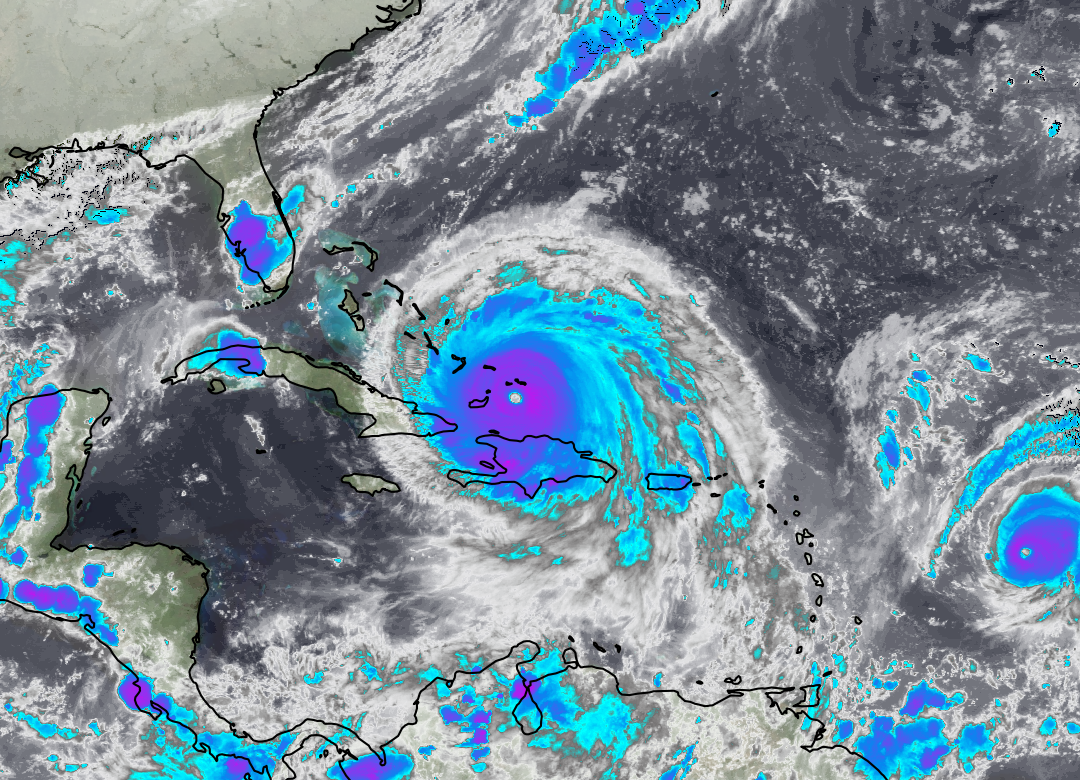

In [11]:
# Crop off the edges 

file = '/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017/MERGEDIR_BOXES/frames_bluemarble/00000926.png'

from PIL import Image

pic = Image.open(file)
width, height = pic.size
pic.crop( (210,70,1290,850) )  #.size 


#pic.size #(1500, 900)
#w, h, w, h and first height is down from top 
# pic.crop( (250,100,1250,800) )  #.size  # (1000, 700)
#pic.crop( (210,70,1290,850) )  #.size 

In [13]:
# Crop them all 

from pathlib import Path; from PIL import Image
SOURCE = Path('/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017/MERGEDIR_BOXES/frames_bluemarble')
OUTPUT = Path('/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017/MERGEDIR_BOXES/frames_bluemarble_crop')
OUTPUT.mkdir(exist_ok=True) 

CROP = (210, 70, 1290, 850)
for f in SOURCE.glob('0000132*.png'): Image.open(f).crop(CROP).save(OUTPUT / f.name)

In [18]:
# 4. Create simple video using ffmpeg
ffmpeg_cmd = [
    "ffmpeg", "-y", "-framerate", "6",
    "-i", str(frame_folder / "%08d.png"),
    "-c:v", "libx264", "-pix_fmt", "yuv420p",
    video_filename
]

print("Creating video...")
run(ffmpeg_cmd)
print(f"✅ Video saved as {video_filename}")

Creating video...


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with clang version 18.1.8
  configuration: --prefix=/Users/bmapes/.local/share/mamba/envs/hk25 --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1746479731466/_build_env/bin/x86_64-apple-darwin13.4.0-clang --enable-neon --disable-gnutls --enable-libvpx --enable-libass --enable-pthreads --enable-libopenvino --enable-gpl --enable-libx264 --enable-libx265 --enable-libmp3lame --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shared --disable-static --enable-version3 --enable-zli

✅ Video saved as /Users/bmapes/Box/Sky_Symphony_Box/IRMA2017/MERGEDIR_BOXES/bluemarble_cropped.mp4


[out#0/mp4 @ 0x600002e34300] video:224241KiB audio:0KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 0.006620%
frame= 1330 fps= 41 q=-1.0 Lsize=  224255KiB time=00:03:41.33 bitrate=8300.2kbits/s speed=6.87x    
[libx264 @ 0x12ea05030] frame I:19    Avg QP:21.61  size:252902
[libx264 @ 0x12ea05030] frame P:662   Avg QP:24.20  size:180442
[libx264 @ 0x12ea05030] frame B:649   Avg QP:24.92  size:162348
[libx264 @ 0x12ea05030] consecutive B-frames: 34.7%  0.5%  0.5% 64.4%
[libx264 @ 0x12ea05030] mb I  I16..4:  2.3% 30.0% 67.7%
[libx264 @ 0x12ea05030] mb P  I16..4:  1.1% 31.3% 41.5%  P16..4:  8.1%  9.9%  7.8%  0.0%  0.0%    skip: 0.2%
[libx264 @ 0x12ea05030] mb B  I16..4:  0.5% 13.3% 36.9%  B16..8: 13.2% 15.4% 10.6%  direct: 8.5%  skip: 1.6%  L0:32.3% L1:28.2% BI:39.4%
[libx264 @ 0x12ea05030] 8x8 transform intra:35.8% inter:31.7%
[libx264 @ 0x12ea05030] coded y,uvDC,uvAC intra: 97.5% 58.6% 35.6% inter: 81.9% 32.2% 19.8%
[libx264 @ 0x12ea05030] i16 v,h,dc,p: 12% 13% 

### Claude's ffmpeg approach to interplating to 8 minutes length 

#Interpolation factor × 1400 frames ÷ target seconds = needed fps
#3x: 4200 frames / 480s = 8.75 fps (8 min) or 7 fps (10 min)
#4x: 5600 frames / 480s = 11.67 fps (8 min) or 9.33 fps (10 min)

##### First create base video
#ffmpeg -y -framerate 6 -i frame_%04d.png -c:v libx264 -pix_fmt yuv420p video_filename

#### Then interpolate and slow down to 8 minutes
##### Target: 480 seconds from 233 seconds = 2.06x slower
##### ffmpeg -i video_filename -filter:v "minterpolate='fps=24',setpts=2.06*PTS" video_filename+'8min.mp4'

In [ ]:
# 4. Interpolate to 8 minutes length using ffmpeg: looks horrible, deleted

ffmpeg_cmd2 = [
    "ffmpeg", "-i", video_filename,
    "-filter:v", "minterpolate='fps=24',setpts=2.06*PTS", 
    video_filename+'.8min.mp4'
]

#ffmpeg_cmd2
# run(ffmpeg_cmd2) --> disappointing weird artifacts 

In [20]:
# Interpolate -->frames4 using rife, 4x after trying 2x which looked nonmonotonic
# problem was it didn't overwrite, so clobber all frames before running this 

import subprocess

frame_folder = Path('/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017/MERGEDIR_BOXES/frames_bluemarble_crop')

# Rename frames for rife 
#for i, f in enumerate(sorted(frame_folder.glob('frame_*.png'))): 
#    f.rename(f.parent / f"{i:08d}.png")
    
framess_folder =Path("/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017/MERGEDIR_BOXES/frames_bmc_4x/")
framess_folder.mkdir(exist_ok=True)

# Run RIFE interpolation to make interleaved frames 
subprocess.run([
    "/Users/bmapes/Box/Sky_Symphony_Box/rife-ncnn-vulkan-20221029-macos/rife-ncnn-vulkan",  # or full path to executable
    "-i", frame_folder,
    "-o", framess_folder,
    "-n", "5328",  # number of frames to generate, 4x (1331+1) since they start at 000000
    "-m", "rife-v4.6"
])

[0 Apple M2]  queueC=0[1]  queueG=0[1]  queueT=0[1]
[0 Apple M2]  bugsbn1=0  bugbilz=0  bugcopc=0  bugihfa=0
[0 Apple M2]  fp16-p/s/a=1/1/1  int8-p/s/a=1/1/1
[0 Apple M2]  subgroup=32  basic=1  vote=1  ballot=1  shuffle=1


CompletedProcess(args=['/Users/bmapes/Box/Sky_Symphony_Box/rife-ncnn-vulkan-20221029-macos/rife-ncnn-vulkan', '-i', PosixPath('/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017/MERGEDIR_BOXES/frames_bluemarble_crop'), '-o', PosixPath('/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017/MERGEDIR_BOXES/frames_bmc_4x'), '-n', '5328', '-m', 'rife-v4.6'], returncode=0)

In [21]:
# Then from interpolated frames make video at desired length
# video_filename = "/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017/MERGEDIR_BOXES/"+"Irma_bmc_4xframes.mp4"

subprocess.run([
    "ffmpeg", "-y",
    "-framerate", "12",  # 11.67 = 5600 frames / 480 sec for 8 min, I have 5328 frames 
    "-i", f"{framess_folder}/%08d.png",
    "-c:v", "libx264", "-pix_fmt", "yuv420p",
    "/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017/Irma_bmc_4xframes_framerate12.mp4"
])

ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with clang version 18.1.8
  configuration: --prefix=/Users/bmapes/.local/share/mamba/envs/hk25 --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1746479731466/_build_env/bin/x86_64-apple-darwin13.4.0-clang --enable-neon --disable-gnutls --enable-libvpx --enable-libass --enable-pthreads --enable-libopenvino --enable-gpl --enable-libx264 --enable-libx265 --enable-libmp3lame --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shared --disable-static --enable-version3 --enable-zli

CompletedProcess(args=['ffmpeg', '-y', '-framerate', '12', '-i', '/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017/MERGEDIR_BOXES/frames_bmc_4x/%08d.png', '-c:v', 'libx264', '-pix_fmt', 'yuv420p', '/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017/Irma_bmc_4xframes_framerate12.mp4'], returncode=0)

In [22]:
!open /Users/bmapes/Box/Sky_Symphony_Box/IRMA2017/Irma_bmc_4xframes_framerate12.mp4

In [5]:
# Test colors for one image 

data_folder = Path("/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017/MERGEDIR_BOXES/ncfiles/")  
nc_files = sorted(data_folder.glob("*.nc"))

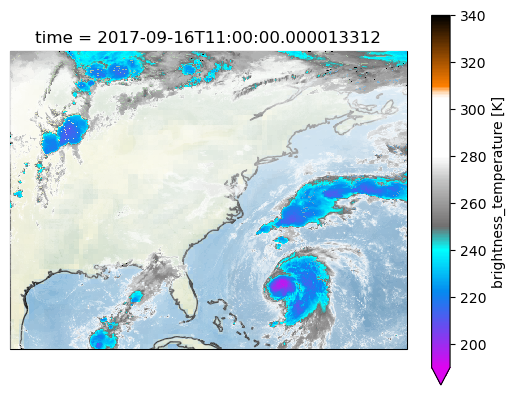

In [30]:
ds = xr.open_dataset(nc_files[-1])  # 21Z = 18+24-15 cold 
Tb = ds.Tb[0]

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([Tb.lon.min(), Tb.lon.max(), Tb.lat.min(), Tb.lat.max()], crs=ccrs.PlateCarree())
ax.stock_img()  # Adds low-res natural Earth background
#ax.add_wmts('https://map1c.vis.earthdata.nasa.gov/wmts-geo/wmts.cgi', 
#            'BlueMarble_NextGeneration')

ax.coastlines()
# ax.add_feature(cfeature.BORDERS, linewidth=0.5)

Tb.plot(ax=ax, cmap=cmap,vmin=vmin,vmax=vmax, transform=ccrs.PlateCarree(), zorder=10, \
       add_colorbar=True);

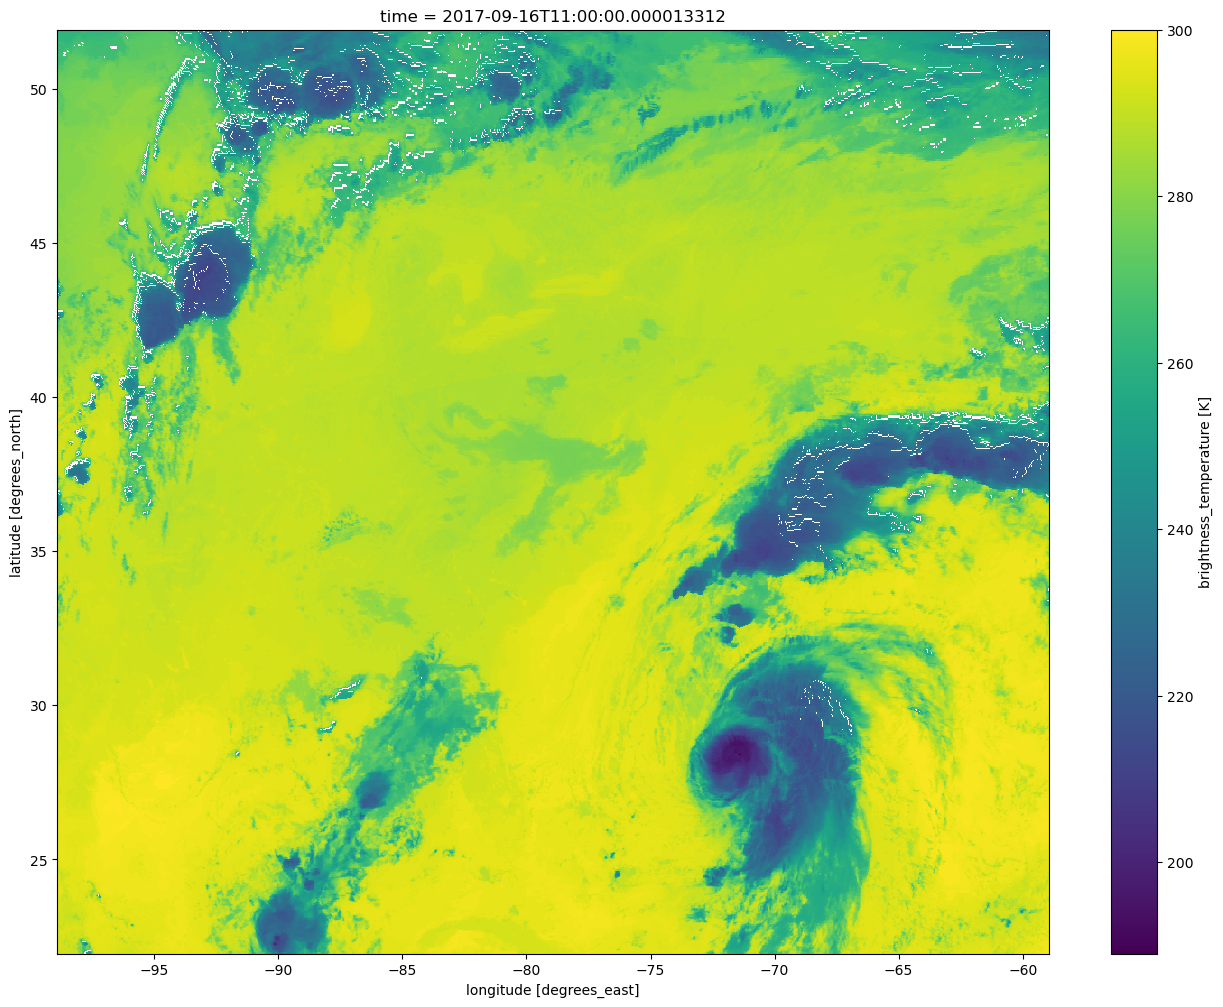

In [33]:
Tb.plot(size=12)

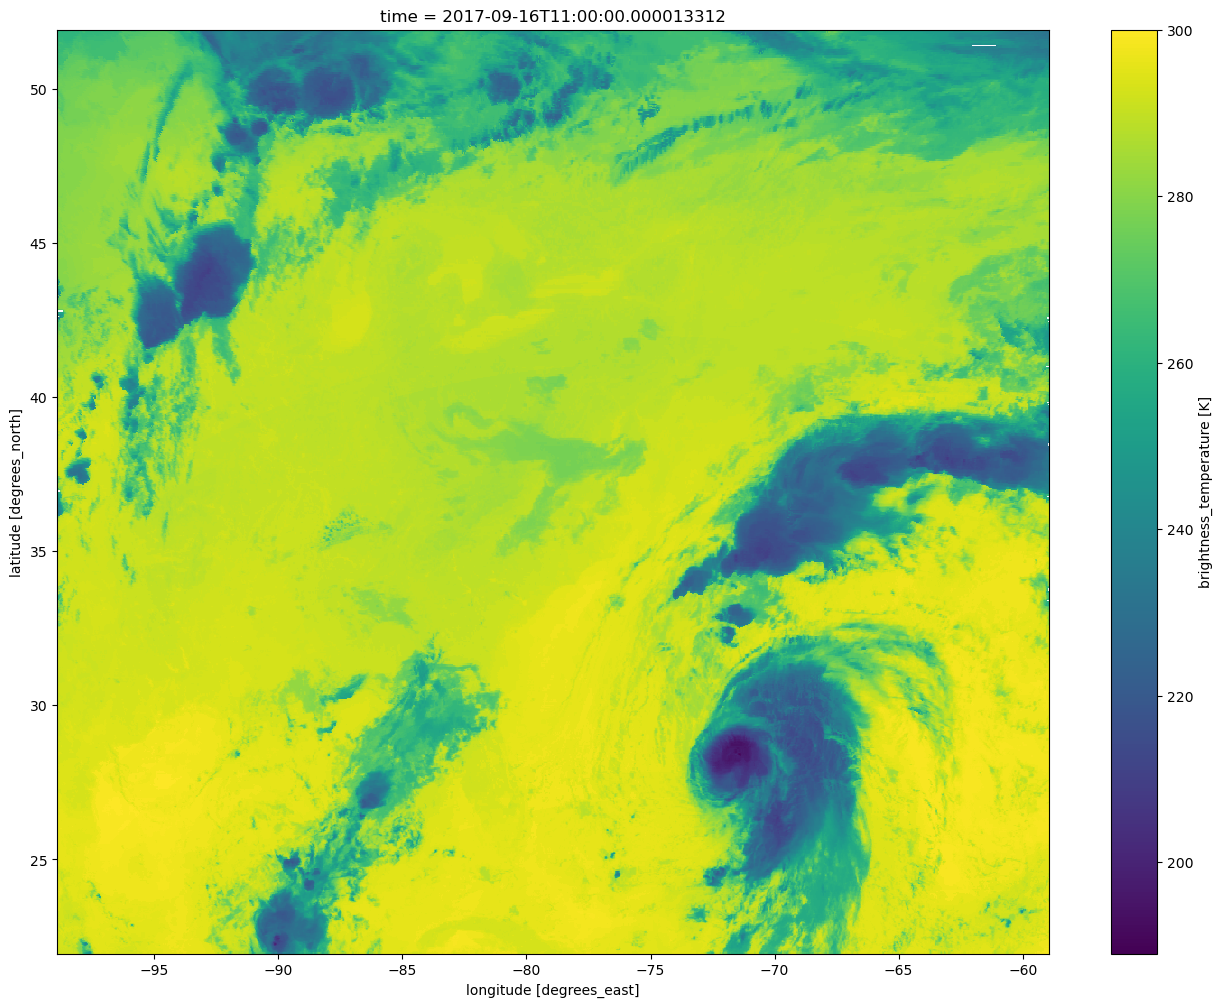

In [37]:
# https://docs.xarray.dev/en/stable/generated/xarray.DataArray.interpolate_na.html
Tb.interpolate_na(dim="lon", method="linear", max_gap=1).plot(size=12)


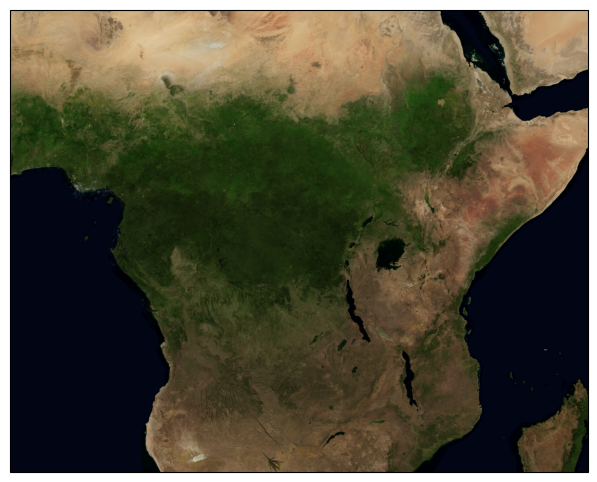

In [14]:
        extent = [
            0, 50,
            -20, 20
        ]
        
        fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        
        # Background image: stock image, or slow web call, tiles keeps crashing on me, sigh
        #ax.stock_img()  # Adds low-res natural Earth background
        #ax.add_wmts('https://map1c.vis.earthdata.nasa.gov/wmts-geo/wmts.cgi', 
        #            'BlueMarble_NextGeneration')
        ax.imshow(BASE_IMAGE_DATA,
          origin='upper',
          transform=ccrs.PlateCarree(),
          extent=FULL_WORLD_EXTENT)
